#### Test the performance of PCA on 3D and 2D data

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from utils.simplePCA import simplePCA
import timeit
# %matplotlib widget

# generate 3D dataset
xyz = np.random.random((500, 3)) * 10.0
xyz[:450, 2:] = xyz[:450, :1]


PCA execution time, 3D dataset: 0.0012814000074286014
1.4751596680653507


<Figure size 800x800 with 0 Axes>

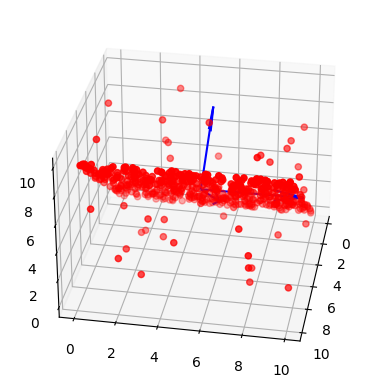

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import timeit
# Assume simplePCA function is defined elsewhere

# 3D PCA
start = timeit.default_timer()
m, eigva, eigve = simplePCA(xyz)
print("PCA execution time, 3D dataset:", timeit.default_timer() - start)
print(np.linalg.norm(eigve,ord=1))
# Scale the eigenvectors and reduce by half
eigve = eigve * 5

fig = plt.figure(figsize=(8, 8))
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c='r')
ax.quiver(m[0], m[1], m[2], eigve[0, :], eigve[1, :], eigve[2, :], color='b', zorder=3)
ax.view_init(azim=10)
plt.show()



[[    -3.5418     -3.5222     0.22227]
 [ -0.0042591     0.31916      4.9898]
 [     3.5292     -3.5344     0.22908]]
PCA execution time, 2D dataset: 0.00036527701013255864


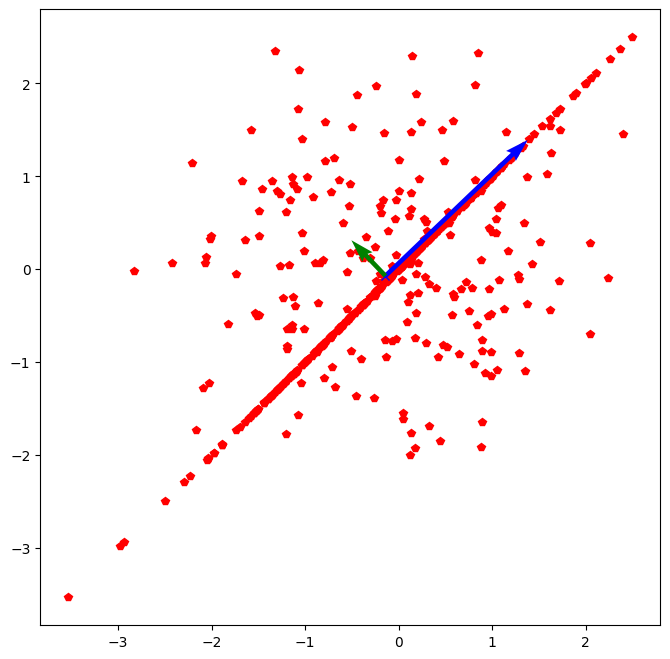

In [23]:
print(eigve)
# Generate 2D dataset, 50% noise
xy = np.random.randn(500, 2)
xy[0:300, 0] = xy[0:300, 1]

start = timeit.default_timer()
m, eigva, eigve = simplePCA(xy)
print("PCA execution time, 2D dataset:", timeit.default_timer() - start)

# Scale the eigenvectors
eigve = eigve * eigva
# Make sure to reshape eigve if necessary
eigve = eigve[:, :2]  # Use the first two dimensions if it's a larger matrix

# Plot the PCA results
plt.figure(figsize=(8, 8))
plt.quiver(m[0], m[1], eigve[0, 0], eigve[1, 0], scale=5.0, color='b', zorder=3)  # Plot the first eigenvector
plt.quiver(m[0], m[1], eigve[0, 1], eigve[1, 1], scale=5.0, color='g', zorder=3)  # Plot the second eigenvector
plt.plot(xy[:, 0], xy[:, 1], 'rp', m[0], m[1], 'bx', zorder=1)
plt.show()


#### The 3D and 2D PCA have been tested above, Now try getting the desired point cloud from rgb and depth image

In [24]:
##              Align Depth to Color               ##
#####################################################

# First import the library
import pyrealsense2 as rs
# Import Numpy for easy array manipulation
import numpy as np
# Import OpenCV for easy image rendering
import cv2

# Create a pipeline
pipeline = rs.pipeline()

# Create a config and configure the pipeline to stream
#  different resolutions of color and depth streams
config = rs.config()

# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

found_rgb = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    exit(0)

config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Start streaming
profile = pipeline.start(config)

# Getting the depth sensor's depth scale (see rs-align example for explanation)
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
print("Depth Scale is: " , depth_scale)
pipeline.stop()
ctx = rs.context()
devices = ctx.query_devices()
for dev in devices:
    dev.hardware_reset()


Depth Scale is:  0.0010000000474974513


- load images for test

#### Test the official API, map the pixel in rgb frame and depth in depth image to xyz

In [ ]:
import pyrealsense2 as rs
import numpy as np
import cv2

# Initialize the pipeline for streaming
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
pipeline.start(config)

# aligner
align_to = rs.stream.color
align = rs.align(align_to)

# Wait for frames
frames = pipeline.wait_for_frames()


aligned_frames = align.process(frames)

# Get depth and color frames
depth_frame = aligned_frames.get_depth_frame()
color_frame = aligned_frames.get_color_frame()

# Validate frames
if not depth_frame or not color_frame:
    print("Error: Could not retrieve frames.")
    exit()

# Convert frames to numpy arrays for further processing
depth_image = np.asanyarray(depth_frame.get_data())
color_image = np.asanyarray(color_frame.get_data())

# Get camera intrinsics for both depth and color
depth_intrinsics = depth_frame.profile.as_video_stream_profile().intrinsics
color_intrinsics = color_frame.profile.as_video_stream_profile().intrinsics

# Load or generate a mask (For demonstration, creating a random binary mask)
# Normally, this mask would come from your object detection pipeline.
mask = np.ones_like(depth_image)

# List to store 3D points
points_3d = []

# Iterate over each pixel in the mask
for y in range(mask.shape[0]):
    for x in range(mask.shape[1]):
        if mask[y, x] == 1:  # If the mask has detected an object at this pixel
            # Get the depth value at the pixel (x, y)
            depth_value = depth_frame.get_distance(x, y)
            
            if 0<depth_value <1.4:  # Only consider valid depth values
                # Convert the 2D pixel to a 3D point using depth intrinsics
                result = rs.rs2_deproject_pixel_to_point(
                    depth_intrinsics, [x, y], depth_value
                )
                points_3d.append(result)

# Print 3D points
for point in points_3d[:20]:  # Printing the first 10 points for brevity
    print(f"3D Point: {point}")

# Stop the pipeline when done
pipeline.stop()




#### Yolo Detection

- import ultralytics package

In [37]:
%matplotlib inline
from ultralytics import YOLO

# Load a model
model = YOLO("weights/best.pt")  # build a new model from scratch

In [38]:
import cv2
import matplotlib.pyplot as plt

rgb_img = color_image
depth_img = depth_image
# rgb_img = cv2.imread('data/leaf.png',cv2.IMREAD_COLOR)
# depth_img = cv2.imread('data/depth_20240908_171007.png',cv2.IMREAD_UNCHANGED)

In [39]:
def bgr2rgb(img:np.ndarray):
    return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

def bbox2mask(xyxy):
    x0, y0, x1, y1 = xyxy
    mask = np.zeros((480, 640)).astype(np.uint8)
    # Create a mask for the YOLO bounding box
    mask = cv2.rectangle(mask, (x0, y0), (x1, y1), (255, 255, 255), -1)
    return mask

In [40]:
import torch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA GeForce RTX 3080 is available.



0: 480x640 2 leafs, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


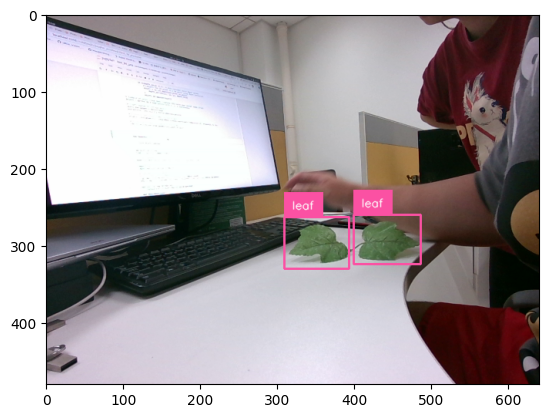

In [42]:
from PIL import Image
import supervision as sv
import copy
%matplotlib inline
results = model(rgb_img, conf=0.2)[0]

bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
# parse detection
detections = sv.Detections.from_ultralytics(results)
annotated_image = bounding_box_annotator.annotate(
scene=copy.deepcopy(bgr2rgb(rgb_img)), detections=detections)
annotated_image = label_annotator.annotate(
scene=annotated_image, detections=detections)
plt.figure()
plt.imshow(annotated_image)
plt.show()

In [43]:
def find_bbox_center(bbox:list)->(np.ndarray, list):
    # find center position of xyxxy bounding box
    return  [int((bbox[0]+bbox[2])/2),
             int((bbox[1]+bbox[3])/2)]
 
def get_bbox_incircle_size(bbox:list):
    w = abs(bbox[0]-bbox[2])
    h = abs(bbox[1]-bbox[3])
    return  int(min(w,h)/10)

    
def get_incircle_bbox(img:np.ndarray=None, 
                      bbox_list:list=None):
    incircle_list = list(map(find_bbox_center, 
                             bbox_list))
    circle_size = list(map(get_bbox_incircle_size, 
                           bbox_list))
    mask_new = np.zeros_like(img)
    img_new = copy.deepcopy(img)
    # Iterate through the bounding boxes and draw circles
    for center, radius in zip(incircle_list, circle_size):
        cv2.circle(mask_new, center, radius, (255, 255, 255), -1)
        cv2.circle(img_new, center, radius, (255, 255, 255), -1)
        
    result = {}
    result['mask'] = mask_new
    result['image'] = img_new
    result['incircle_list'] = incircle_list
    return result
    
# def create_segmented_image(img:np.ndarray, )

In [44]:
bbox_leaf = results.boxes.xyxy.tolist()

result = get_incircle_bbox(img=rgb_img, bbox_list=bbox_leaf)

In [ ]:
plt.figure()
plt.imshow(bgr2rgb(result['image']))
plt.show()

In [46]:
from ultralytics import SAM
from functools import reduce
# Load the model
model = SAM("weights/sam_l.pt")


In [47]:
# Predict a segment based on a box prompt
incircle_list = result['incircle_list']
result_sam = model.predict(rgb_img, points=incircle_list, bboxes=bbox_leaf, labels=[1])[0]

result_mask_combined = reduce(lambda x, y: x + y, result_sam.masks.data.cpu().numpy())
result_mask_list = result_sam.masks.data.cpu().numpy()


0: 1024x1024 329.3ms
Speed: 4.1ms preprocess, 329.3ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)


In [48]:
xy = np.where(result_sam.masks.data.cpu().numpy()[0]==1)

In [49]:
def preprocess2PCA(result_masks:list)->list:
    xy_list = []
    for mask in result_masks:
        xy = np.where(mask==1)
        xy = np.array(xy).transpose()
        xy = np.fliplr(xy)
        xy_list.append(xy)
    return xy_list
        

In [50]:
xy_pca = preprocess2PCA(result_sam.masks.data.cpu().numpy())

In [51]:
xy_pca = xy_pca[1]

In [52]:
xy_pca.shape

(2603, 2)

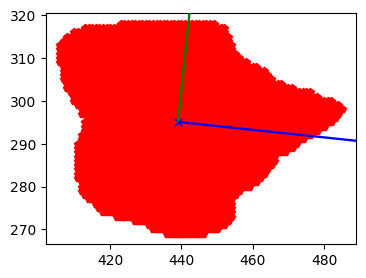

In [53]:
m, eigva, eigve = simplePCA(xy_pca)
# Scale the eigenvectors
eigve = eigve * eigva
# Make sure to reshape eigve if necessary
eigve = eigve[:, :2]  # Use the first two dimensions if it's a larger matrix

# Plot the PCA results
plt.figure(figsize=(4, 3))
plt.quiver(m[0], m[1], eigve[0, 0], eigve[1, 0], scale=5.0, color='b', zorder=3)  # Plot the first eigenvector
plt.quiver(m[0], m[1], eigve[0, 1], eigve[1, 1], scale=5.0, color='g', zorder=3)  # Plot the second eigenvector
plt.plot(xy_pca[:,0], xy_pca[:,1], 'rp', m[0], m[1], 'bx', zorder=1)
plt.show()

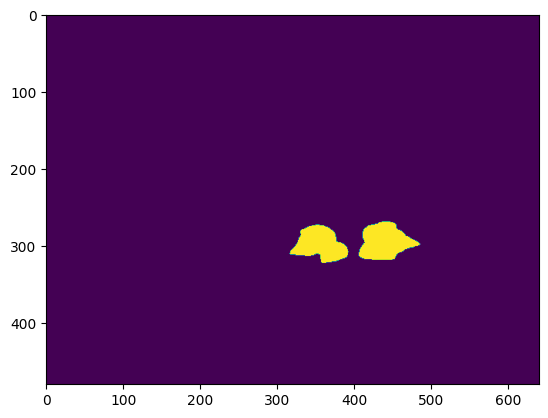

In [54]:
plt.imshow(result_mask_combined)

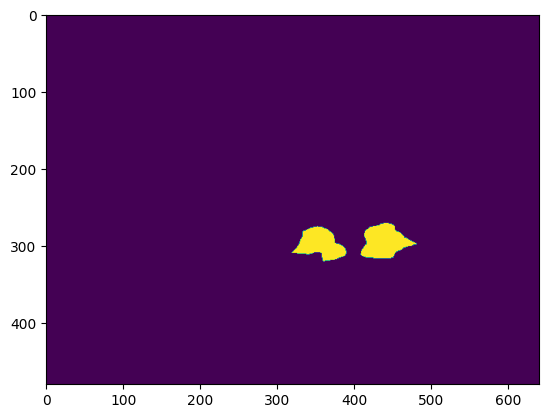

In [55]:
import cv2
import numpy as np

# Load a binary image (ensure it's a binary image or convert to binary first)
img = result_mask_combined.astype(np.uint8)

# Create a binary threshold if necessary (0 and 255)
_, binary_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Define a kernel (structuring element) for the opening operation
kernel = np.ones((5, 5), np.uint8)  # 5x5 kernel of ones

# # Perform the opening operation (erosion followed by dilation)
# opened_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
# opened_img = cv2.morphologyEx(opened_img, cv2.MORPH_OPEN, kernel)

# Apply erosion to shrink the mask
shrunk_mask = cv2.erode(img, kernel, iterations=1)  # i
plt.imshow(shrunk_mask)

In [ ]:
import open3d as o3d
import numpy as np
# List to store 3D points
points_3d = []

# Iterate over each pixel in the mask
for y in range(mask.shape[0]):
    for x in range(mask.shape[1]):
        if shrunk_mask[y, x] == 1:  # If the mask has detected an object at this pixel
            # Get the depth value at the pixel (x, y)
            depth_value = depth_frame.get_distance(x, y)
            
            if 0<depth_value <1.4:  # Only consider valid depth values
                # Convert the 2D pixel to a 3D point using depth intrinsics
                result = rs.rs2_deproject_pixel_to_point(
                    depth_intrinsics, [x, y], depth_value
                )
                points_3d.append(result)

# Example of point cloud data (replace this with your actual numpy array)
points = points_3d # 1000 points with x, y, z coordinates

# Create Open3D PointCloud object
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Create a coordinate frame for the origin
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.05, origin=[0, 0, 0])

# Visualize the point cloud with the origin
o3d.visualization.draw_geometries([pcd, origin])

In [56]:
# List to store 3D points
points_3d = []

# Iterate over each pixel in the mask
for y in range(result_mask_combined.shape[0]):
    for x in range(result_mask_combined.shape[1]):
        if mask[y, x] == 1:  # If the mask has detected an object at this pixel
            # Get the depth value at the pixel (x, y)
            depth_value = depth_frame.get_distance(x, y)
            
            if depth_value > 0:  # Only consider valid depth values
                # Convert the 2D pixel to a 3D point using depth intrinsics
                result = rs.rs2_deproject_pixel_to_point(
                    depth_intrinsics, [x, y], depth_value
                )
                points_3d.append(result)

In [57]:
points_3d

[[0.2732391357421875, -2.0345070362091064, 3.260000228881836],
 [0.2810822129249573, -2.0289056301116943, 3.251000165939331],
 [0.28967976570129395, -2.028921604156494, 3.251000165939331],
 [0.29745179414749146, -2.0233209133148193, 3.242000102996826],
 [0.30527088046073914, -2.0183451175689697, 3.2340002059936523],
 [0.3129507005214691, -2.0127451419830322, 3.2250001430511475],
 [0.3205832839012146, -2.007145643234253, 3.2160000801086426],
 [0.3281683623790741, -2.0015463829040527, 3.207000255584717],
 [0.33665087819099426, -2.0015642642974854, 3.207000255584717],
 [0.34416502714157104, -1.9959653615951538, 3.198000192642212],
 [0.3517420291900635, -1.9909911155700684, 3.190000057220459],
 [0.36018022894859314, -1.9910099506378174, 3.190000057220459],
 [0.3686186969280243, -1.9910295009613037, 3.190000057220459],
 [0.37705737352371216, -1.9910492897033691, 3.190000057220459],
 [0.38440871238708496, -1.9854516983032227, 3.181000232696533],
 [0.39393550157546997, -1.9910895824432373, 3.

In [58]:
import open3d as o3d

In [59]:
import open3d as o3d
import numpy as np

# Example of point cloud data (replace this with your actual numpy array)
points = points_3d # 1000 points with x, y, z coordinates

# Create Open3D PointCloud object
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd])
